Initializing classifier with memory optimization...
Loading dataset...
Scanning dataset structure...

Found plant: apple
  - Alternaria leaf spot: 278 images
  - Brown spot: 215 images
  - Gray spot: 395 images
  - Healthy leaf: 409 images
  - Rust: 344 images

Found plant: tomato
  - Tomato___Bacterial_spot: 1000 images
  - Tomato___Early_blight: 1000 images
  - Tomato___Late_blight: 1000 images
  - Tomato___Leaf_Mold: 1000 images
  - Tomato___Septoria_leaf_spot: 1000 images
  - Tomato___Spider_mites Two-spotted_spider_mite: 1000 images
  - Tomato___Target_Spot: 9 images

Dataset Summary:
Total plants: 2 - ['apple', 'tomato']
Total diseases: 12 - ['Alternaria leaf spot', 'Brown spot', 'Gray spot', 'Healthy leaf', 'Rust', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot']
Total classes: 12
Cleaning up old temporary directory: temp_flat_d

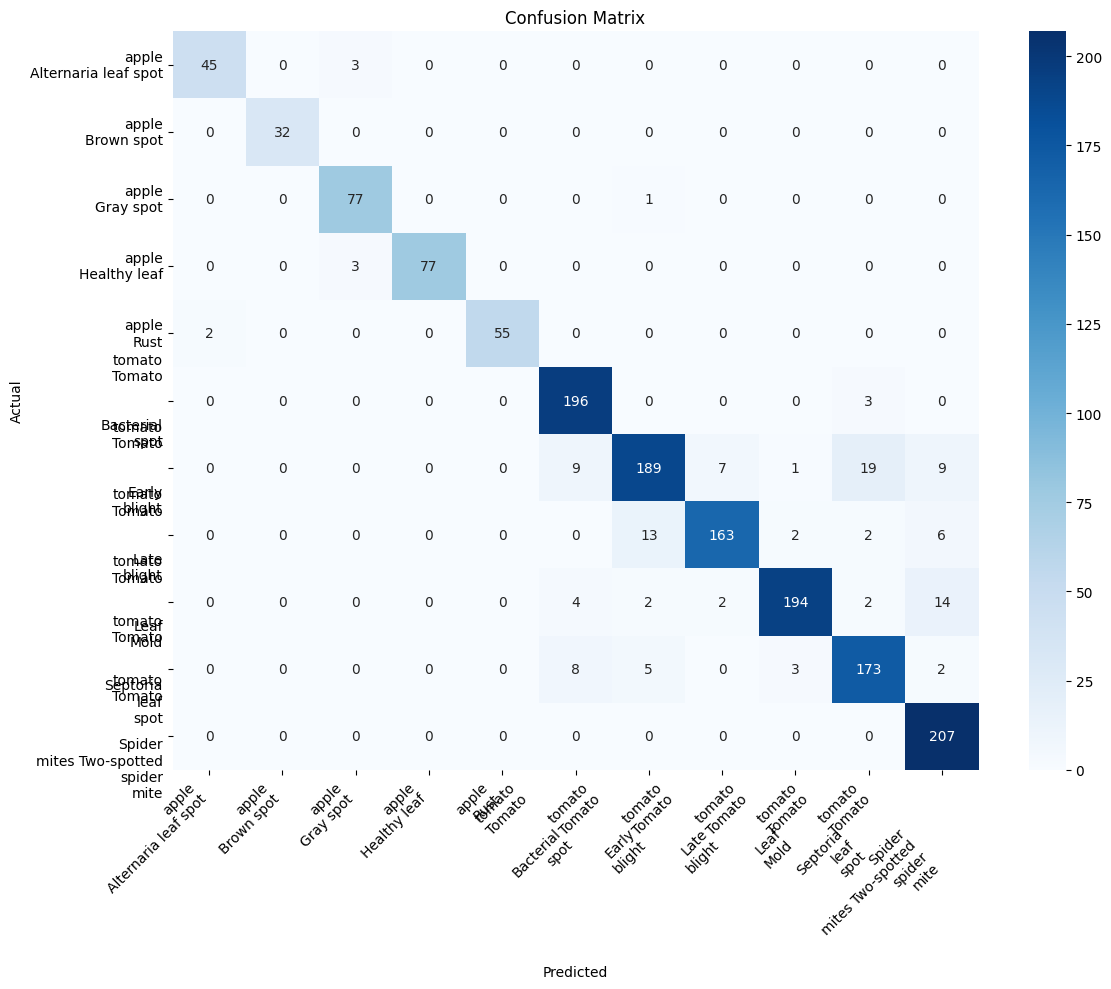


Overall Validation Accuracy: 0.9203
Model saved to ../models\plant_disease_model_fixed.keras
Metadata saved to ../models\plant_disease_model_fixed_metadata.pkl

Training completed successfully!
Final validation accuracy: 0.9203
Starting cleanup...
Removing temporary directory: temp_flat_dataset_1b1bb949
Successfully removed temp_flat_dataset_1b1bb949
Cleanup completed successfully!
Cleanup process finished.


In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import shutil
import time
import stat
import gc

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Memory optimization settings
tf.config.experimental.enable_memory_growth = True
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Reduce TensorFlow logging

class PlantDiseaseClassifier:
    def __init__(self, data_dir, img_size=(224, 224), batch_size=16):
        self.data_dir = data_dir
        self.img_size = img_size
        self.batch_size = batch_size
        self.model = None
        self.history = None
        self.class_names = None
        self.plant_names = None
        self.disease_names = None
        self.class_mapping = {}
        self.temp_dir = None
        self.train_ds = None
        self.val_ds = None

    def robust_rmtree(self, path, max_retries=5, delay=1):
        """Robust directory removal for Windows"""
        if not os.path.exists(path):
            return True
            
        # First, try to close any TensorFlow datasets that might be using the files
        if hasattr(self, 'train_ds') and self.train_ds is not None:
            del self.train_ds
        if hasattr(self, 'val_ds') and self.val_ds is not None:
            del self.val_ds
        
        # Force garbage collection
        gc.collect()
        
        for attempt in range(max_retries):
            try:
                # Change permissions recursively to make files deletable
                for root, dirs, files in os.walk(path):
                    for d in dirs:
                        os.chmod(os.path.join(root, d), stat.S_IWRITE)
                    for f in files:
                        file_path = os.path.join(root, f)
                        try:
                            os.chmod(file_path, stat.S_IWRITE)
                        except:
                            pass
                
                # Try to remove the directory
                shutil.rmtree(path, ignore_errors=False)
                print(f"Successfully removed {path}")
                return True
                
            except Exception as e:
                print(f"Attempt {attempt + 1} failed to remove {path}: {e}")
                if attempt < max_retries - 1:
                    print(f"Waiting {delay} seconds before retry...")
                    time.sleep(delay)
                    delay *= 2  # Exponential backoff
                else:
                    print(f"Failed to remove {path} after {max_retries} attempts")
                    # Try alternative approach
                    return self.alternative_cleanup(path)
        
        return False

    def alternative_cleanup(self, path):
        """Alternative cleanup method - rename and schedule for deletion"""
        try:
            # Rename to a temp name for later cleanup
            import uuid
            temp_name = f"temp_to_delete_{uuid.uuid4().hex[:8]}"
            new_path = os.path.join(os.path.dirname(path), temp_name)
            os.rename(path, new_path)
            print(f"Renamed {path} to {new_path} for later cleanup")
            
            # Try to remove files individually
            self.remove_files_individually(new_path)
            return True
            
        except Exception as e:
            print(f"Alternative cleanup also failed: {e}")
            print("You may need to manually delete the temporary directory later")
            return False

    def remove_files_individually(self, path):
        """Remove files one by one"""
        for root, dirs, files in os.walk(path, topdown=False):
            # Remove files first
            for file in files:
                file_path = os.path.join(root, file)
                try:
                    os.chmod(file_path, stat.S_IWRITE)
                    os.remove(file_path)
                except:
                    pass
            
            # Then remove empty directories
            for dir in dirs:
                dir_path = os.path.join(root, dir)
                try:
                    os.rmdir(dir_path)
                except:
                    pass
        
        # Finally try to remove the root directory
        try:
            os.rmdir(path)
        except:
            pass

    def scan_dataset_structure(self):
        """Scan the dataset to understand the structure and create class mappings"""
        print("Scanning dataset structure...")
        
        if not os.path.exists(self.data_dir):
            raise FileNotFoundError(f"Dataset directory '{self.data_dir}' not found.")
        
        plants = []
        diseases = []
        class_names = []
        class_mapping = {}
        
        class_index = 0
        for plant_name in sorted(os.listdir(self.data_dir)):
            plant_path = os.path.join(self.data_dir, plant_name)
            if os.path.isdir(plant_path):
                print(f"\nFound plant: {plant_name}")
                for disease_name in sorted(os.listdir(plant_path)):
                    disease_path = os.path.join(plant_path, disease_name)
                    if os.path.isdir(disease_path):
                        # Count images in this category
                        image_count = len([f for f in os.listdir(disease_path) 
                                         if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))])
                        print(f"  - {disease_name}: {image_count} images")
                        
                        # Create class name and mapping
                        class_name = f"{plant_name}_{disease_name}"
                        class_names.append(class_name)
                        class_mapping[class_index] = (plant_name, disease_name)
                        
                        if plant_name not in plants:
                            plants.append(plant_name)
                        if disease_name not in diseases:
                            diseases.append(disease_name)
                        
                        class_index += 1
        
        self.plant_names = plants
        self.disease_names = diseases
        self.class_names = class_names
        self.class_mapping = class_mapping
        
        print(f"\nDataset Summary:")
        print(f"Total plants: {len(plants)} - {plants}")
        print(f"Total diseases: {len(diseases)} - {diseases}")
        print(f"Total classes: {len(class_names)}")
        
        return class_names, class_mapping

    def create_flat_structure(self):
        """Create a flat structure for keras to process with improved cleanup"""
        import uuid
        flat_dir = f"temp_flat_dataset_{uuid.uuid4().hex[:8]}"
        self.temp_dir = flat_dir
        
        # Clean up any existing temp directories first
        self.cleanup_old_temp_dirs()
        
        if os.path.exists(flat_dir):
            print(f"Removing existing {flat_dir}...")
            self.robust_rmtree(flat_dir)
        
        os.makedirs(flat_dir)
        print(f"Creating flat dataset structure in {flat_dir}...")
        
        try:
            for plant_name in os.listdir(self.data_dir):
                plant_path = os.path.join(self.data_dir, plant_name)
                if os.path.isdir(plant_path):
                    for disease_name in os.listdir(plant_path):
                        disease_path = os.path.join(plant_path, disease_name)
                        if os.path.isdir(disease_path):
                            # Create flattened class name
                            flat_class_name = f"{plant_name}_{disease_name}"
                            flat_class_path = os.path.join(flat_dir, flat_class_name)
                            
                            # Copy the directory
                            shutil.copytree(disease_path, flat_class_path)
            
            print(f"Flat structure created successfully in {flat_dir}")
            return flat_dir
            
        except Exception as e:
            print(f"Error creating flat structure: {e}")
            # Clean up on error
            self.robust_rmtree(flat_dir)
            raise

    def cleanup_old_temp_dirs(self):
        """Clean up any old temporary directories"""
        current_dir = os.getcwd()
        for item in os.listdir(current_dir):
            if item.startswith("temp_flat_dataset") and os.path.isdir(item):
                print(f"Cleaning up old temporary directory: {item}")
                self.robust_rmtree(item)

    def load_data(self, validation_split=0.2):
        """Load and prepare the dataset with memory optimization"""
        # First scan the structure
        self.scan_dataset_structure()
        
        # Create flat structure
        flat_data_dir = self.create_flat_structure()
        
        print(f"\nLoading dataset with {len(self.class_names)} classes...")
        print(f"Using batch size: {self.batch_size}")
        
        try:
            # Create datasets with memory-efficient settings
            self.train_ds = tf.keras.utils.image_dataset_from_directory(
                flat_data_dir,
                validation_split=validation_split,
                subset="training",
                seed=42,
                image_size=self.img_size,
                batch_size=self.batch_size,
                class_names=self.class_names
            )
            
            self.val_ds = tf.keras.utils.image_dataset_from_directory(
                flat_data_dir,
                validation_split=validation_split,
                subset="validation",
                seed=42,
                image_size=self.img_size,
                batch_size=self.batch_size,
                class_names=self.class_names
            )
            
            print(f"Training samples: {len(self.train_ds) * self.batch_size}")
            print(f"Validation samples: {len(self.val_ds) * self.batch_size}")
            
            # Optimize dataset performance
            AUTOTUNE = tf.data.AUTOTUNE
            self.train_ds = self.train_ds.cache().shuffle(500).prefetch(buffer_size=AUTOTUNE)
            self.val_ds = self.val_ds.cache().prefetch(buffer_size=AUTOTUNE)
            
            return self.train_ds, self.val_ds
            
        except Exception as e:
            print(f"Error loading data: {e}")
            # Clean up on error
            if flat_data_dir:
                self.robust_rmtree(flat_data_dir)
            raise

    def create_data_augmentation(self):
        """Create data augmentation layers"""
        return keras.Sequential([
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.1),
            layers.RandomContrast(0.1),
        ])

    def create_model(self, use_transfer_learning=True, lightweight=True):
        """Create the model architecture"""
        num_classes = len(self.class_names)
        
        if use_transfer_learning:
            if lightweight:
                base_model = tf.keras.applications.MobileNetV2(
                    input_shape=(*self.img_size, 3),
                    include_top=False,
                    weights='imagenet',
                    alpha=0.75
                )
                base_model.trainable = False
                print(f"Using lightweight MobileNetV2 (alpha=0.75)")
            else:
                base_model = tf.keras.applications.MobileNetV2(
                    input_shape=(*self.img_size, 3),
                    include_top=False,
                    weights='imagenet'
                )
                base_model.trainable = False
                print(f"Using standard MobileNetV2")
            
            data_augmentation = self.create_data_augmentation()
            preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
            
            inputs = keras.Input(shape=(*self.img_size, 3))
            x = data_augmentation(inputs)
            x = preprocess_input(x)
            x = base_model(x, training=False)
            x = layers.GlobalAveragePooling2D()(x)
            x = layers.Dropout(0.2)(x)
            outputs = layers.Dense(num_classes, activation='softmax')(x)
            model = keras.Model(inputs, outputs)
            
        else:
            data_augmentation = self.create_data_augmentation()
            model = keras.Sequential([
                data_augmentation,
                layers.Rescaling(1./255),
                layers.Conv2D(32, 3, padding='same', activation='relu'),
                layers.BatchNormalization(),
                layers.MaxPooling2D(),
                layers.Conv2D(64, 3, padding='same', activation='relu'),
                layers.BatchNormalization(),
                layers.MaxPooling2D(),
                layers.Conv2D(128, 3, padding='same', activation='relu'),
                layers.BatchNormalization(),
                layers.MaxPooling2D(),
                layers.Flatten(),
                layers.Dense(256, activation='relu'),
                layers.Dropout(0.3),
                layers.Dense(num_classes, activation='softmax')
            ])
            print("Using lightweight custom CNN")
        
        self.model = model
        return model

    def compile_model(self, learning_rate=0.001):
        """Compile the model"""
        self.model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        print("Model compiled successfully!")
        print(f"Model has {self.model.count_params():,} parameters")

    def train_model(self, epochs=15, callbacks=None):
        """Train the model"""
        if callbacks is None:
            callbacks = [
                keras.callbacks.EarlyStopping(
                    monitor='val_loss', 
                    patience=5, 
                    restore_best_weights=True,
                    verbose=1
                ),
                keras.callbacks.ReduceLROnPlateau(
                    monitor='val_loss', 
                    factor=0.2, 
                    patience=3, 
                    min_lr=1e-7,
                    verbose=1
                )
            ]
        
        print("Starting training...")
        print(f"Batch size: {self.batch_size}")
        print(f"Max epochs: {epochs}")
        
        try:
            self.history = self.model.fit(
                self.train_ds,
                validation_data=self.val_ds,
                epochs=epochs,
                callbacks=callbacks,
                verbose=1
            )
        except Exception as e:
            print(f"Training error: {e}")
            raise
        
        return self.history

    def plot_training_history(self):
        """Plot training history"""
        if self.history is None:
            print("No training history available. Train the model first.")
            return
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot accuracy
        ax1.plot(self.history.history['accuracy'], label='Training Accuracy', marker='o')
        ax1.plot(self.history.history['val_accuracy'], label='Validation Accuracy', marker='s')
        ax1.set_title('Model Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot loss
        ax2.plot(self.history.history['loss'], label='Training Loss', marker='o')
        ax2.plot(self.history.history['val_loss'], label='Validation Loss', marker='s')
        ax2.set_title('Model Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

    def evaluate_model(self):
        """Evaluate the model and show detailed metrics"""
        print("Evaluating model...")
        
        y_pred, y_true = [], []
        for images, labels in self.val_ds:
            predictions = self.model.predict(images, verbose=0)
            y_pred.extend(np.argmax(predictions, axis=1))
            y_true.extend(labels.numpy())
        
        unique_classes = sorted(list(set(y_true + y_pred)))
        present_class_names = [self.class_names[i] for i in unique_classes]
        
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, 
                                  labels=unique_classes,
                                  target_names=present_class_names))
        
        # Confusion Matrix
        cm = confusion_matrix(y_true, y_pred, labels=unique_classes)
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=[name.replace('_', '\n') for name in present_class_names], 
                    yticklabels=[name.replace('_', '\n') for name in present_class_names])
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
        
        accuracy = np.sum(np.array(y_true) == np.array(y_pred)) / len(y_true)
        print(f"\nOverall Validation Accuracy: {accuracy:.4f}")
        
        return accuracy

    def save_model(self, filename="plant_disease_model.keras"):
        """Save the trained model"""
        models_dir = "../models"
        os.makedirs(models_dir, exist_ok=True)
        filepath = os.path.join(models_dir, filename)
        
        self.model.save(filepath)
        
        # Save metadata
        import pickle
        metadata = {
            'class_names': self.class_names,
            'class_mapping': self.class_mapping,
            'plant_names': self.plant_names,
            'disease_names': self.disease_names,
            'img_size': self.img_size
        }
        
        metadata_filename = filename.replace('.keras', '_metadata.pkl')
        metadata_filepath = os.path.join(models_dir, metadata_filename)
        
        with open(metadata_filepath, 'wb') as f:
            pickle.dump(metadata, f)
        
        print(f"Model saved to {filepath}")
        print(f"Metadata saved to {metadata_filepath}")

    def cleanup(self):
        """Enhanced cleanup with robust directory removal"""
        print("Starting cleanup...")
        
        # Close datasets first
        if hasattr(self, 'train_ds') and self.train_ds is not None:
            del self.train_ds
            self.train_ds = None
        
        if hasattr(self, 'val_ds') and self.val_ds is not None:
            del self.val_ds
            self.val_ds = None
        
        # Force garbage collection
        gc.collect()
        
        # Clean up the specific temp directory if it exists
        if hasattr(self, 'temp_dir') and self.temp_dir and os.path.exists(self.temp_dir):
            print(f"Removing temporary directory: {self.temp_dir}")
            success = self.robust_rmtree(self.temp_dir)
            if success:
                print("Cleanup completed successfully!")
            else:
                print("Cleanup completed with some issues - check for remaining temp directories")
        
        # Clean up any other temp directories
        self.cleanup_old_temp_dirs()
        
        print("Cleanup process finished.")

def main():
    """Main function with improved error handling"""
    data_dir = "my_diseases_dataset"
    classifier = None
    
    try:
        # Initialize classifier
        print("Initializing classifier with memory optimization...")
        classifier = PlantDiseaseClassifier(data_dir, img_size=(224, 224), batch_size=8)
        
        # Load data
        print("Loading dataset...")
        train_ds, val_ds = classifier.load_data(validation_split=0.2)
        
        # Create model
        print("Creating model...")
        model = classifier.create_model(use_transfer_learning=True, lightweight=True)
        classifier.compile_model(learning_rate=0.001)
        
        # Train model
        print("Training model...")
        history = classifier.train_model(epochs=10)
        
        # Evaluate
        accuracy = classifier.evaluate_model()
        
        # Save model
        classifier.save_model("plant_disease_model_fixed.keras")
        
        print(f"\nTraining completed successfully!")
        print(f"Final validation accuracy: {accuracy:.4f}")
        
    except FileNotFoundError:
        print(f"Dataset directory '{data_dir}' not found.")
        print("Please ensure your dataset is in the correct location.")
        
    except Exception as e:
        print(f"Error during training: {e}")
        import traceback
        traceback.print_exc()
        
    finally:
        # Always try to cleanup, even if there were errors
        if classifier is not None:
            try:
                classifier.cleanup()
            except Exception as cleanup_error:
                print(f"Error during cleanup: {cleanup_error}")
                print("You may need to manually delete temporary directories")

if __name__ == "__main__":
    main()